# Q Function
* used to approximate the reward based on a state
* Q(s,a) calculates the expected future value from state **s** and action **a**
* in DQN, we use a **neural network to approximate the reward**

# Classes
* Environment
* Agent
* Runner

## Environment

In [1]:
class Action:
    def __init__(self, act, days, percentage):
        self.act = act
        self.days = days
        self.percentage = percentage

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime

BUY = 'buy'
SELL = 'sell'
SKIP = 'skip'

class Environment:
    
    min_days_to_hold = 5
    max_days_to_hold = 10
    
    def __init__(self, 
                 ticker, 
                 initial_deposit = 100000,
                 from_date = datetime.datetime(2007, 1, 1), 
                 to_date = datetime.datetime(2017, 1, 1),
                 window = 20):
        self.initial_deposit = initial_deposit
        self.window = window
        self.data = pdr.get_data_google(ticker, from_date, to_date)
        self.pct_data = self.data.pct_change().fillna(0)
        self.data_length = len(self.data)
        
        actions = np.array([BUY, SELL, SKIP])
        days_to_holds = np.arange(Environment.min_days_to_hold, 
                                  Environment.max_days_to_hold + 1,
                                  1)
        
        self.action_space = [Action(act, days, 3) for act in actions for days in days_to_holds]
        self.reset()
        
    def reset(self):
        self.deposit = self.initial_deposit
        self.current_index = self.window
        self.actions = {}
        
        return self.state()
    
    def score(self):
        return self.deposit
    
    def enough_data_provided(self):
        return self.current_index + Environment.max_days_to_hold <= self.data_length
    
    def state(self):
        return self.pct_data.iloc[self.current_index - self.window:self.current_index]['Close']
    
    # def price_state(self):
    #    return self.data.iloc[self.current_index - self.window:self.current_index]['Close']
        
    def state_size(self):
        return self.window
    
    def action_size(self):
        return len(self.action_space)
        
    def step(self, action_idx: int):
        action = self.action_space[action_idx]
        #print('\t=> current action is: {} at {}'.format(action, self.data.index[self.current_index]))
        
        df = self.data.iloc[self.current_index: self.current_index + action.days]
        on_date = df.index[0]
        first_day_price = df.iloc[0]['Close']
        last_day_price = df.iloc[-1]['Close']
        
        if action.act == BUY:
            reward = last_day_price - first_day_price
        elif action.act == SELL:
            reward = first_day_price - last_day_price
        elif action.act == SKIP:
            reward = 0
            
        self.actions[on_date] = (action, reward)
        
        self.current_index += action.days
        self.deposit += reward * (self.deposit*action.percentage/100)
        
        next_state = self.state()
        done = False
        _ = None
        return next_state, reward, done, _ 

## Agent

In [3]:
import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import mean_squared_error

class Agent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.99
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
    
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(36, input_dim=self.state_size, activation='relu'))
        model.add(Dense(18, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=mean_squared_error,
                      optimizer=Adam(lr=self.learning_rate))
        return model
    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)
            if done:
                target[0][action] = reward
            else:
                a = self.model.predict(next_state)[0]
                t = self.target_model.predict(next_state)[0]
                target[0][action] = reward + self.gamma * t[np.argmax(a)]
            self.model.fit(state, target, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

Using TensorFlow backend.


## Runner

In [4]:
env = Environment('AAPL')
state_size = env.state_size()
action_size = env.action_size()
print('Action size: {}, state size: {}'.format(action_size, state_size))

Action size: 18, state size: 20


In [5]:
agent = Agent(state_size, action_size)
EPISODES = 500
batch_size = 32

In [6]:
max_reward = None
for e in range(EPISODES):
    state = env.reset()
    state = state.values.reshape([1, state_size])
    while env.enough_data_provided():
        action_idx = agent.act(state)
        next_state, reward, done, _ = env.step(action_idx) # build these parameters into the NN model
        # reward = reward if not done else -10
        next_state = next_state.values.reshape([1, state_size])
        agent.remember(state, action_idx, reward, next_state, done)
        state = next_state
    
    if max_reward is None or max_reward[0] < env.score():
        max_reward = (env.score(), env.actions)
    
    agent.update_target_model()
    print("episode: {}/{}, score: {}, e: {:.2}".format(e, EPISODES, env.score(), agent.epsilon))
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)
print(max_reward)

episode: 0/500, score: 57122.85146883436, e: 1.0
episode: 1/500, score: 22220.66284026751, e: 0.99
episode: 2/500, score: 13387.1913698759, e: 0.98
episode: 3/500, score: 28502.13852021033, e: 0.97
episode: 4/500, score: 17988.881560821785, e: 0.96
episode: 5/500, score: 38413.36809896992, e: 0.95
episode: 6/500, score: 26648.83197482975, e: 0.94
episode: 7/500, score: 5337.0269162037, e: 0.93
episode: 8/500, score: 20352.79861007939, e: 0.92
episode: 9/500, score: 26072.605715846275, e: 0.91
episode: 10/500, score: 327512.30073796795, e: 0.9
episode: 11/500, score: 4350.512652124427, e: 0.9
episode: 12/500, score: 81690.40371783279, e: 0.89
episode: 13/500, score: 120688.2082329691, e: 0.88
episode: 14/500, score: 240868.32859759088, e: 0.87
episode: 15/500, score: 101254.32687496547, e: 0.86
episode: 16/500, score: 198578.88834492155, e: 0.85
episode: 17/500, score: 4095.7537184041516, e: 0.84
episode: 18/500, score: 207773.37321469345, e: 0.83
episode: 19/500, score: 76160.646498606

episode: 159/500, score: 30081.460478340887, e: 0.2
episode: 160/500, score: 149579.77290005644, e: 0.2
episode: 161/500, score: 286625.1100804207, e: 0.2
episode: 162/500, score: 467929.9219601848, e: 0.2
episode: 163/500, score: 25649.95982833443, e: 0.19
episode: 164/500, score: 121553.38832086742, e: 0.19
episode: 165/500, score: 58912.23958664733, e: 0.19
episode: 166/500, score: 2742151.980208525, e: 0.19
episode: 167/500, score: 289940.8754235475, e: 0.19
episode: 168/500, score: 399367.4505717856, e: 0.18
episode: 169/500, score: 32322.610391290535, e: 0.18
episode: 170/500, score: 199260.7465764467, e: 0.18
episode: 171/500, score: 1869196.105101338, e: 0.18
episode: 172/500, score: 140858.71889105684, e: 0.18
episode: 173/500, score: 214325.9943332975, e: 0.18
episode: 174/500, score: 56546.2207119232, e: 0.17
episode: 175/500, score: 500212.0498414659, e: 0.17
episode: 176/500, score: 326008.19093219616, e: 0.17
episode: 177/500, score: 32805.96459291717, e: 0.17
episode: 17

episode: 315/500, score: 185328.7017287158, e: 0.05
episode: 316/500, score: 385351.9431639752, e: 0.05
episode: 317/500, score: 350357.69255242887, e: 0.05
episode: 318/500, score: 391554.23385109723, e: 0.05
episode: 319/500, score: 303240.22278114664, e: 0.05
episode: 320/500, score: 207657.54777230983, e: 0.05
episode: 321/500, score: 1698107.9703512352, e: 0.05
episode: 322/500, score: 663398.8848523922, e: 0.05
episode: 323/500, score: 235305.10712884314, e: 0.05
episode: 324/500, score: 162653.60542702695, e: 0.05
episode: 325/500, score: 128892.36120669916, e: 0.05
episode: 326/500, score: 564353.8152530881, e: 0.05
episode: 327/500, score: 322089.6156892124, e: 0.05
episode: 328/500, score: 198046.94614631223, e: 0.05
episode: 329/500, score: 111730.84350056013, e: 0.05
episode: 330/500, score: 131808.1198215119, e: 0.05
episode: 331/500, score: 98578.38890424602, e: 0.05
episode: 332/500, score: 555200.850964826, e: 0.05
episode: 333/500, score: 753535.1737721891, e: 0.05
epi

episode: 472/500, score: 349284.0565796957, e: 0.05
episode: 473/500, score: 361646.0151778693, e: 0.05
episode: 474/500, score: 706642.4609429259, e: 0.05
episode: 475/500, score: 371251.26316408336, e: 0.05
episode: 476/500, score: 353867.2536532125, e: 0.05
episode: 477/500, score: 186854.77079110456, e: 0.05
episode: 478/500, score: 512290.82674507325, e: 0.05
episode: 479/500, score: 286857.7720606817, e: 0.05
episode: 480/500, score: 578887.4290055578, e: 0.05
episode: 481/500, score: 180901.76063653157, e: 0.05
episode: 482/500, score: 112428.7621375088, e: 0.05
episode: 483/500, score: 590814.7602662715, e: 0.05
episode: 484/500, score: 843215.2646653455, e: 0.05
episode: 485/500, score: 436383.5122152602, e: 0.05
episode: 486/500, score: 405104.9016669547, e: 0.05
episode: 487/500, score: 333008.96446273034, e: 0.05
episode: 488/500, score: 927432.289041556, e: 0.05
episode: 489/500, score: 620644.4303013693, e: 0.05
episode: 490/500, score: 189388.36048271795, e: 0.05
episode

In [7]:
signals = np.array([[], [], []]).T
signals.shape

(0, 3)

In [14]:
max_reward[0]

3085975.0823783386

In [8]:
for key, value in max_reward[1].items():
    print('Date: {} => Action: {} => Reward: {}'.format(key, value[0].act, value[1]))
    signals = np.concatenate((signals, np.array([[key, value[0].act, env.data.loc[key]['Close']]])), axis = 0)

Date: 2007-02-01 00:00:00 => Action: buy => Reward: 0.20000000000000107
Date: 2007-02-08 00:00:00 => Action: skip => Reward: 0
Date: 2007-02-16 00:00:00 => Action: buy => Reward: 0.6000000000000014
Date: 2007-02-26 00:00:00 => Action: buy => Reward: -0.46000000000000085
Date: 2007-03-05 00:00:00 => Action: buy => Reward: 0.2400000000000002
Date: 2007-03-12 00:00:00 => Action: buy => Reward: -0.03999999999999915
Date: 2007-03-19 00:00:00 => Action: buy => Reward: 0.33999999999999986
Date: 2007-03-26 00:00:00 => Action: buy => Reward: -0.41999999999999993
Date: 2007-04-02 00:00:00 => Action: buy => Reward: 0.0
Date: 2007-04-10 00:00:00 => Action: buy => Reward: -0.40000000000000036
Date: 2007-04-17 00:00:00 => Action: buy => Reward: 1.209999999999999
Date: 2007-04-27 00:00:00 => Action: buy => Reward: 0.07000000000000028
Date: 2007-05-04 00:00:00 => Action: buy => Reward: 0.9299999999999997
Date: 2007-05-11 00:00:00 => Action: buy => Reward: 0.10000000000000142
Date: 2007-05-18 00:00:00 

Date: 2015-02-10 00:00:00 => Action: buy => Reward: 5.810000000000002
Date: 2015-02-18 00:00:00 => Action: buy => Reward: 3.4499999999999886
Date: 2015-02-25 00:00:00 => Action: buy => Reward: 0.5700000000000216
Date: 2015-03-04 00:00:00 => Action: buy => Reward: -4.029999999999987
Date: 2015-03-11 00:00:00 => Action: buy => Reward: 4.800000000000011
Date: 2015-03-18 00:00:00 => Action: buy => Reward: -1.7800000000000011
Date: 2015-03-25 00:00:00 => Action: buy => Reward: 1.0500000000000114
Date: 2015-04-01 00:00:00 => Action: buy => Reward: 1.3499999999999943
Date: 2015-04-09 00:00:00 => Action: buy => Reward: 0.21999999999999886
Date: 2015-04-16 00:00:00 => Action: buy => Reward: 2.450000000000003
Date: 2015-04-23 00:00:00 => Action: buy => Reward: -1.0300000000000011
Date: 2015-04-30 00:00:00 => Action: skip => Reward: 0
Date: 2015-05-11 00:00:00 => Action: buy => Reward: 2.450000000000017
Date: 2015-05-18 00:00:00 => Action: buy => Reward: 2.3499999999999943
Date: 2015-05-26 00:00:

In [9]:
signals.shape

(468, 3)

In [10]:
signals_df = pd.DataFrame(signals)

In [11]:
signals_df.set_index(keys = [0], inplace=True)

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

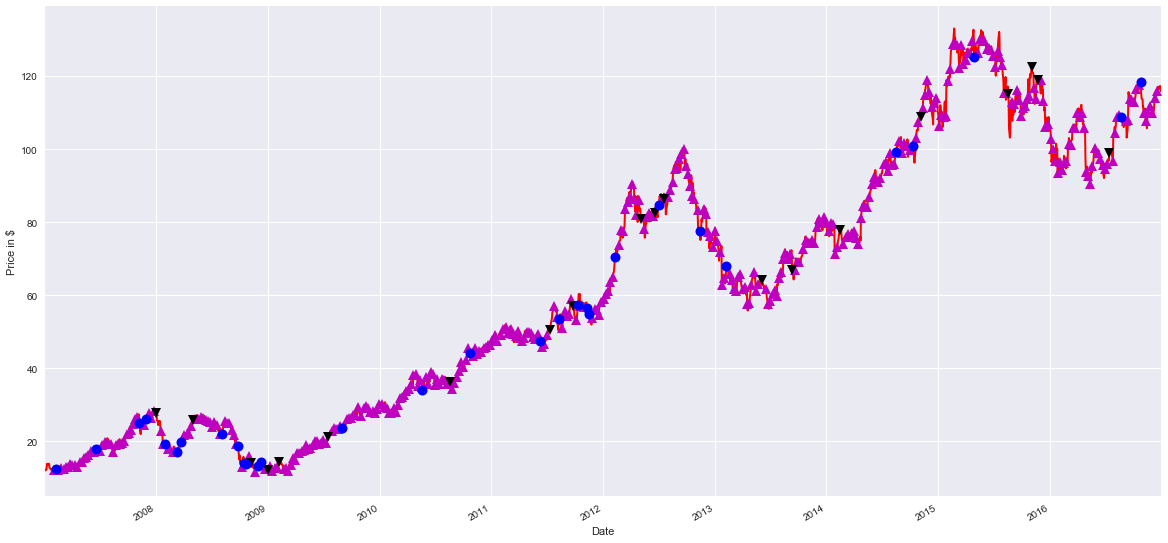

In [15]:
fig = plt.figure(figsize=(20,10))

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
env.data['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the buy signals
ax1.plot(signals_df.loc[signals_df[1] == 'buy'].index, 
         signals_df.loc[signals_df[1] == 'buy'][2],
         '^', markersize=10, color='m')

ax1.plot(signals_df.loc[signals_df[1] == 'sell'].index, 
         signals_df.loc[signals_df[1] == 'sell'][2],
         'v', markersize=10, color='k')

ax1.plot(signals_df.loc[signals_df[1] == 'skip'].index, 
         signals_df.loc[signals_df[1] == 'skip'][2],
         'o', markersize=10, color='b')
                  
# Show the plot
plt.show()